$$D_{KL} \space (Q \space || \space P) = \int_{z} \space Q(z) \log \frac{Q(z)}{P(z)} dz$$
<br><br>
$$D_{KL} \space (q_{\phi}(z) \space || \space p_{\theta}(z)) = \int_{z} \space q_{\phi}(z) \log \frac{q_{\phi}(z)}{p_{\theta}(z)} dz$$
<br><br>
+ We'll use the following shorthands:
    + $q_{\phi}(z) = q_{\phi}(z | x)$
    + $p_{\theta}(z) = p_{\theta}(z | x)$
<br><br>    
$$ = \mathbb{E}_{q_{\phi}} \left[ \log{\frac{q_{\phi}}{p_{\theta}}} \right] $$
<br><br>    
$$ = \mathbb{E}_{q_{\phi}} \left[ \log{q_{\phi}} \right] - \mathbb{E}_{q_{\phi}} \left[ \log{p_{\theta}} \right] $$
<br><br>
$$p_{\theta}(z) = p_{\theta}(z | x)$$
<br><br>
$$p_{\theta}(z | x ) = \frac{p_{\theta}(z) \cdot p_{\theta}(x | z)}{p_{\theta}(x)}$$
<br><br>
$$p_{\theta}(x) \cdot p_{\theta}(z | x) = p_{\theta}(z) \cdot p_{\theta}(x | z) = p_{\theta}(z, x)$$
<br><br>
$$D_{KL} \space (q_{\phi}(z) \space || \space p_{\theta}(z)) = \mathbb{E}_{q_{\phi}} \left[ \log{q_{\phi}} \right] - \mathbb{E}_{q_{\phi}} \left[ \frac{p_{\theta}(z, x)}{p_{\theta}(x)} \right]$$
<br><br>
$$D_{KL} \space (q_{\phi}(z) \space || \space p_{\theta}(z)) = \mathbb{E}_{q_{\phi}} \left[ \log{q_{\phi}} \right] - \mathbb{E}_{q_{\phi}} \left[ \log p_{\theta}(z, x)\right] + \mathbb{E}_{q_{\phi}} \left[ \log{p_{\theta}(x)} \right]$$
<br><br>
$$D_{KL} \space (q_{\phi}(z) \space || \space p_{\theta}(z)) = \log p_{\theta}(x) - \mathbb{E}_{q_{\phi}} \left[ \log{q_{\phi}} \right] - \mathbb{E}_{q_{\phi}} \left[ \log p_{\theta}(z, x)\right]$$
<br><br>
$$D_{KL} \space (q_{\phi}(z) \space || \space p_{\theta}(z)) = \log p_{\theta}(x) - \mathbb{E}_{q_{\phi}} \left[ \log{q_{\phi}} -  \log p_{\theta}(z, x)\right]$$
<br><br>
$$\log p_{\theta}(x) = D_{KL} \space (q_{\phi}(z) \space || \space p_{\theta}(z)) + \mathbb{E}_{q_{\phi}} \left[ \log{q_{\phi}} -  \log p_{\theta}(z, x)\right]$$
<br><br>
$$\log p_{\theta}(x) ≥ \mathbb{E}_{q_{\phi}} \left[ \log{q_{\phi}} -  \log p_{\theta}(z, x)\right]$$

<img src="images/kl_divergence.png" width=500>

+ ELBO term = $\mathbb{E}_{q_{\phi}} \left[ \log{q_{\phi}} -  \log p_{\theta}(z, x)\right]$.<br><br>
+ ELBO term = $\mathbb{E}_{q_{\phi}} \left[ \log{q_{\phi}(z|x)} -  \log p_{\theta}(z, x)\right]$.<br><br>
+ Maximizing the ELBO = Minimizing the negative of ELBO.<br><br>

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import math
import zipfile
import requests
import os
from pathlib import Path

In [2]:
mnist_dataset_test = datasets.MNIST(root='../data/', train=False,
                               transform=transforms.ToTensor(), download=True)

mnist_loader_test = DataLoader(dataset=mnist_dataset_test, batch_size=32, shuffle=True)

In [3]:
mnist_dataset = datasets.MNIST(root='../data/', train=True,
                               transform=transforms.ToTensor(), download=True)

mnist_loader = DataLoader(dataset=mnist_dataset, batch_size=32, shuffle=True)

> ### Visualizing the data

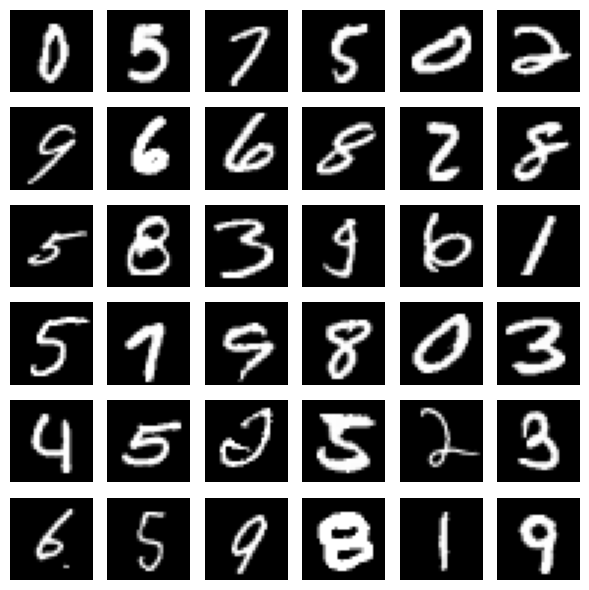

In [4]:
indices = random.sample(range(len(mnist_dataset)), 36)
fig = plt.figure(figsize=(6, 6))
rows, cols = 6, 6
for i, idx in enumerate(indices):
    image, _ = mnist_dataset[idx]
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.imshow(image.permute(1, 2, 0), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

> #### Reparameterization technique

By keeping all of the randomness of the layer contained within the variable epsilon, the partial derivative of the layer output with respect to its input can be shown to be deterministic (i.e., independent of therandom epsilon), which is essential for backpropagation through the layer to be possible.<br><br>

+ The network provides the log variance: $\log \sigma^2$.<br><br>
+ To retrieve the variance ($σ^2$) from the log variance, we apply the inverse of the logarithm, which is the exponential function. By exponentiating both sides of the equation, we get:
$$\sigma^2 = e^{\log \sigma^2}$$
<br><br>
+ Since the standard deviation is the square root of the variance , we take the square root of the variance:
$$\sigma = \sqrt{\sigma^2}$$
<br><br>
$$\sigma = \sqrt{e^{\log \sigma^2}}$$
+ The square root can be expressed as a power of $\frac{1}{2}$:
<br><br>
$$\sigma = {(e^{\log \sigma^2})}^{\frac{1}{2}}$$
<br><br>
+ Applying the exponential property: ${(a^m)}^n = a^{mxn}$.
<br><br>
$$\sigma = {e^{\log \sigma^2}} \cdot ^{\frac{1}{2}}$$

In [5]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [92]:
class CNN_VAE(nn.Module):
       
    def __init__(self, input_channels=1, h_dims=[32, 64], latent_dims=2):
        super(CNN_VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=h_dims[0],
                      kernel_size=3, stride=2, padding=1),                     
            nn.ReLU(),
            
            nn.Conv2d(in_channels=h_dims[0], out_channels=h_dims[1],
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )        
        
        self.fc_mean = nn.Linear(h_dims[1] * 7 * 7, latent_dims)
        self.fc_log_var = nn.Linear(h_dims[1] * 7 * 7, latent_dims)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, h_dims[1] * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (h_dims[1],  7, 7)),
            nn.ConvTranspose2d(in_channels=h_dims[1], out_channels=h_dims[0],
                      kernel_size=3, stride=2, padding=1, output_padding=1),                     
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=h_dims[0], out_channels=input_channels,
                      kernel_size=3, stride=2, padding=1, output_padding=1),            
            nn.ReLU(),
        )        

        
    def encode(self, x):    
        result = self.encoder(x)
        x = torch.flatten(result, start_dim=1)
        enc_mean = self.fc_mean(x)
        enc_log_var = self.fc_log_var(x)        
        return (enc_mean, enc_log_var)
    
    @staticmethod
    def reparameterize(enc_mean, enc_log_var):
        std = torch.exp(0.5 * enc_log_var)
        eps = torch.randn_like(std)
        return enc_mean + eps * std
    
    def decode(self, z):    
        return self.decoder(z)
    
    def forward(self, x):
        enc_mean, enc_log_var = self.encode(x)
        z = self.reparameterize(enc_mean, enc_log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, enc_mean, enc_log_var

In [95]:
BETA = 1.0

def train_model(model, train_loader, optimizer, num_epochs=15):
    model.train()
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1} of {num_epochs}')
        
        total_loss_train, total_reconstruction_loss, total_kl_loss = 0, 0, 0
        
        for batch, _ in train_loader:
            inputs = batch
            
            x_reconstructed, en_mean, en_log_var = model(inputs)
            
            reconstruction_loss = nn.functional.mse_loss(x_reconstructed, inputs,
                                                        reduction='sum')                   
            
            kl_loss = -0.5 * torch.sum(1 + en_log_var - en_mean**2 - en_log_var.exp())        
                        
            total_loss = reconstruction_loss + kl_loss
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            total_loss_train += total_loss.item()
            total_reconstruction_loss += reconstruction_loss.item()
            total_kl_loss += kl_loss.item()
        
        avg_loss_train = total_loss_train / len(train_loader)
        avg_reconstruction_loss = total_reconstruction_loss / len(train_loader)
        avg_kl_loss = total_kl_loss / len(train_loader)
        
        print(f'Train Loss: {avg_loss_train:.3f}, '
              f'Reconstruction Loss: {avg_reconstruction_loss:.3f}, '
              f'KL Loss: {avg_kl_loss:.3f}')        

In [96]:
model = CNN_VAE()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [97]:
train_model(model, mnist_loader, optimizer)

Epoch 1 of 15
Train Loss: 1588.039, Reconstruction Loss: 1490.538, KL Loss: 97.500
Epoch 2 of 15
Train Loss: 1332.836, Reconstruction Loss: 1210.689, KL Loss: 122.148
Epoch 3 of 15
Train Loss: 1295.042, Reconstruction Loss: 1166.592, KL Loss: 128.450
Epoch 4 of 15
Train Loss: 1284.951, Reconstruction Loss: 1153.598, KL Loss: 131.352
Epoch 5 of 15
Train Loss: 1277.816, Reconstruction Loss: 1144.595, KL Loss: 133.220
Epoch 6 of 15
Train Loss: 1272.966, Reconstruction Loss: 1138.095, KL Loss: 134.871
Epoch 7 of 15
Train Loss: 1269.150, Reconstruction Loss: 1133.296, KL Loss: 135.854
Epoch 8 of 15
Train Loss: 1266.031, Reconstruction Loss: 1129.482, KL Loss: 136.549
Epoch 9 of 15
Train Loss: 1264.465, Reconstruction Loss: 1126.850, KL Loss: 137.616
Epoch 10 of 15
Train Loss: 1262.188, Reconstruction Loss: 1124.356, KL Loss: 137.831
Epoch 11 of 15
Train Loss: 1260.157, Reconstruction Loss: 1121.387, KL Loss: 138.770
Epoch 12 of 15
Train Loss: 1259.267, Reconstruction Loss: 1119.739, KL Loss

In [98]:
torch.save(model.state_dict(), 'cnn_vae_model.pth')
torch.save(optimizer.state_dict(), 'cnn_vae_optimizer.pth')
# model = CNN_VAE()
# model.load_state_dict(torch.load('cnn_vae_model.pth'))
# optimizer = optim.Adam(model.parameters(), lr=0.003)
# optimizer.load_state_dict(torch.load('cnn_vae_optimizer.pth'))

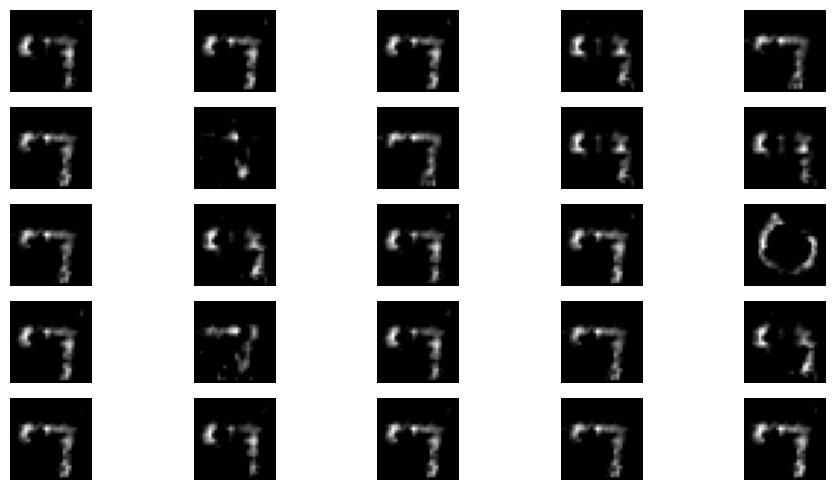

In [101]:
digit = 4
num_examples = 25
digit_images = mnist_dataset.data[mnist_dataset.targets == digit]
random_indices = torch.randperm(len(digit_images))[:num_examples]
selected_images = digit_images[random_indices]
selected_labels = mnist_dataset.targets[mnist_dataset.targets == digit][random_indices]
model.eval()
selected_images_float = selected_images.unsqueeze(dim=1).float()
x_reconstructed, enc_mean, enc_log_var = model(selected_images_float)
plt.figure(figsize=(10, 5))
for i in range(num_examples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_reconstructed[i].squeeze().detach().numpy(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [28]:
from torch.utils.data import DataLoader, Subset
subset_indices = list(range(30_000))
mnist_subset = Subset(mnist_dataset, subset_indices)

mnist_loader_v = DataLoader(dataset=mnist_subset, batch_size=32, shuffle=True)

print(f"Number of batches: {len(mnist_loader_v)}")

Number of batches: 938


In [102]:
from sklearn.preprocessing import MinMaxScaler

def visualize_latens(dataloader, model):
    model.eval()
    all_latents = []
    all_labels = []    
    with torch.no_grad():
        for batch, labels in dataloader:            
            batch = batch.to(next(model.parameters()).device)            
            enc_mean, enc_var = model.encode(batch)
            all_latents.append(model.reparameterize(enc_mean, enc_var).numpy())
            all_labels.append(labels.cpu().numpy())                        
    all_latents = np.concatenate(all_latents, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)    
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(all_latents[:, 0], all_latents[:, 1], c=all_labels, cmap='tab10', alpha=0.8)
    plt.colorbar(scatter, label='Digits')
    plt.title("Visualization of Latent Space")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.grid(True)
    plt.show()
    return all_latents

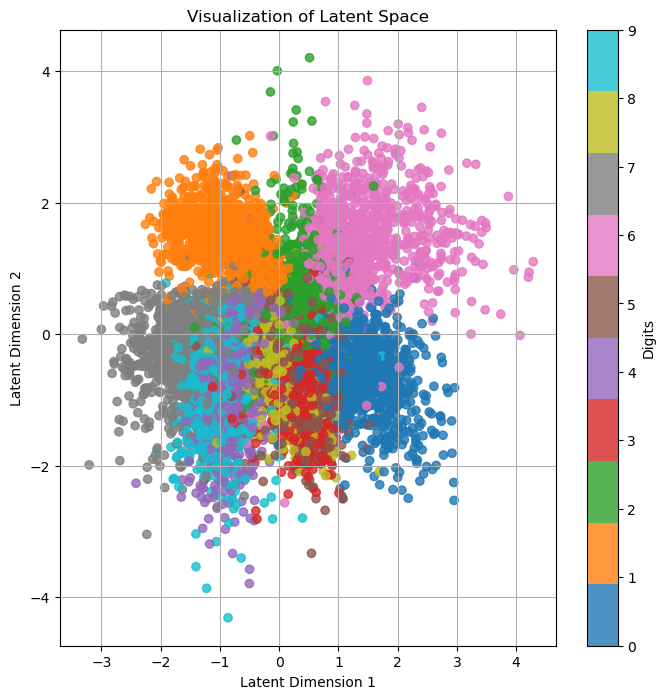

In [103]:
all_latents = visualize_latens(mnist_loader_test, model)

In [104]:
x_1 = np.linspace(-4, 4, 30)
x_2 = np.linspace(-4, 4, 30)

In [101]:
model.eval()
all_images_results = []
for x in x_1:
    for y in x_2:
        input_to_decoder = torch.tensor([x, y], dtype=torch.float32)
        output_from_decoder = model.decode(input_to_decoder.unsqueeze(dim=0))
        all_images_results.append(output_from_decoder)
all_images_results = [image_result.detach().numpy() for image_result in all_images_results]        
all_images_results = [image_result.squeeze() for image_result in all_images_results]
all_images_results = np.array(all_images_results)

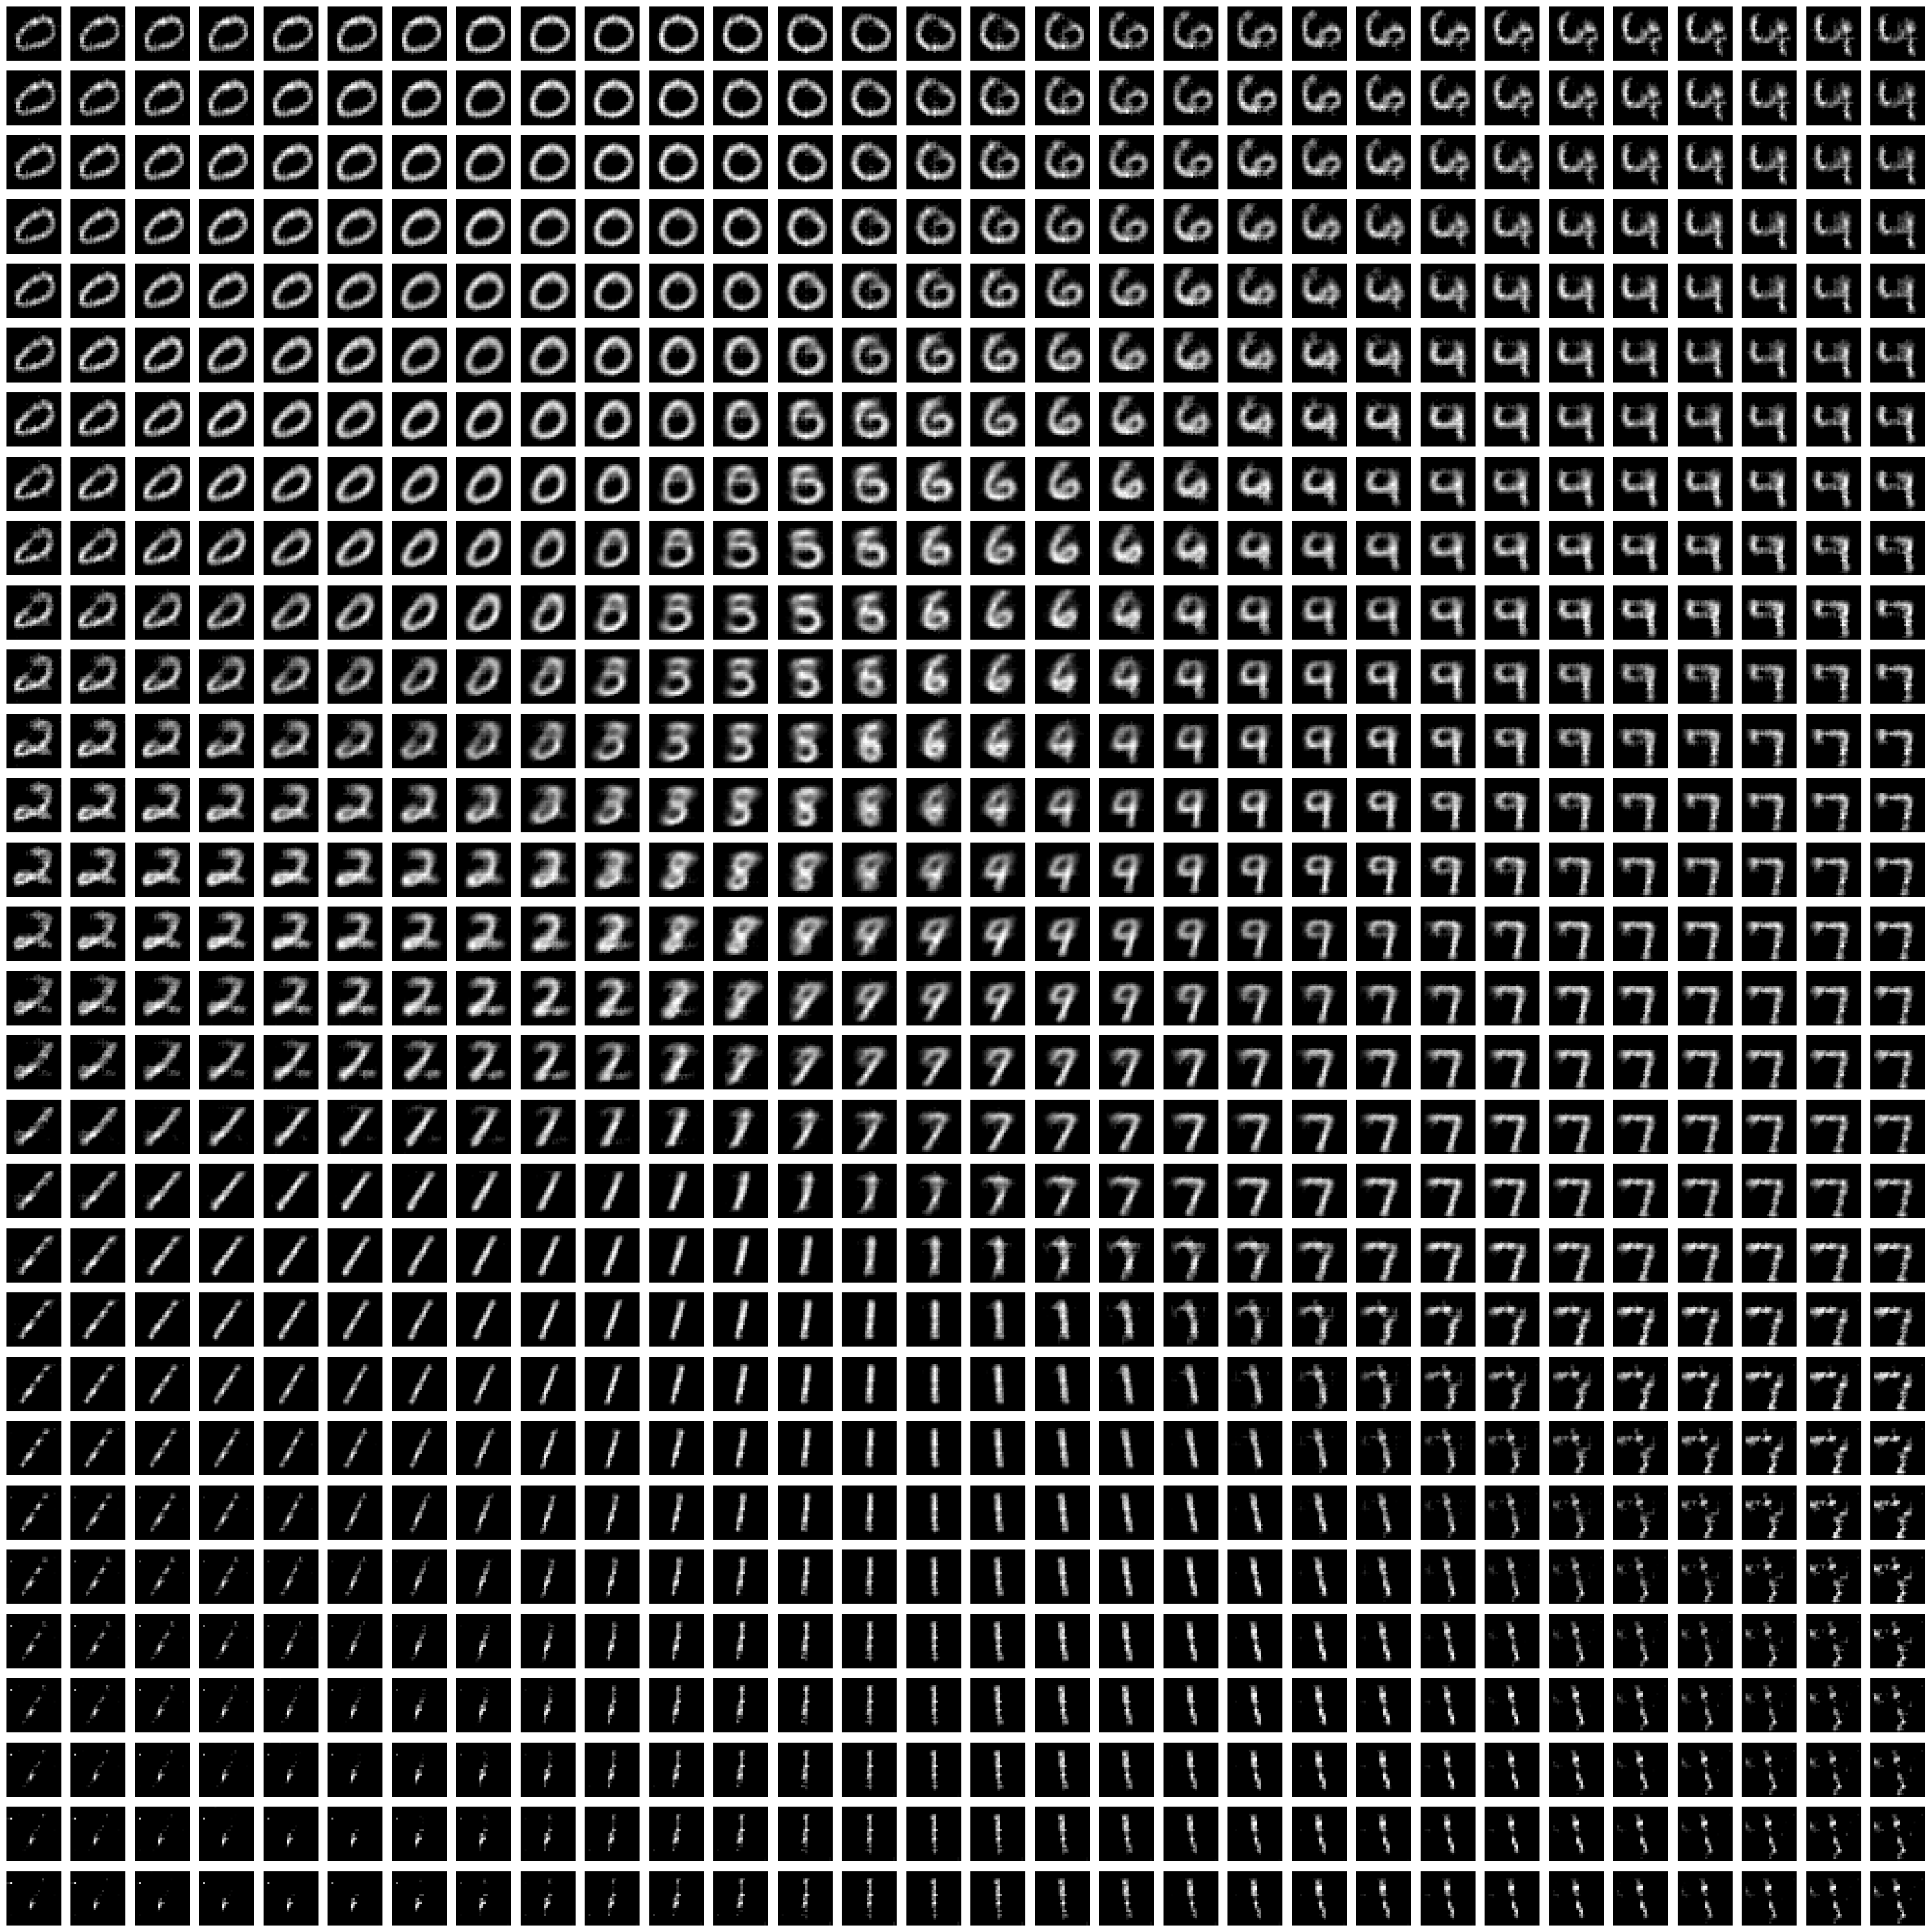

In [102]:
plt.figure(figsize=(30, 30))
for i in range(900):
    plt.subplot(30, 30, i + 1)
    plt.imshow(all_images_results[i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()